In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import models
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import utils
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

import timm
from timm.data import resolve_model_data_config
from timm.data.transforms_factory import create_transform

import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

/home/hhz/anaconda3/envs/hhz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gradients_visualization import VanillaGradient, IntegratedGradients, BlurIG, GuidedIG

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gradients Visualization

Since gradients visualization does not involve extracting specific layer features, it should be directly applicable to various network architectures.

In [4]:
model = timm.create_model('resnet18', pretrained=True)
model = model.to(device)
model.eval()
config = resolve_model_data_config(model, None)
transform = create_transform(**config)

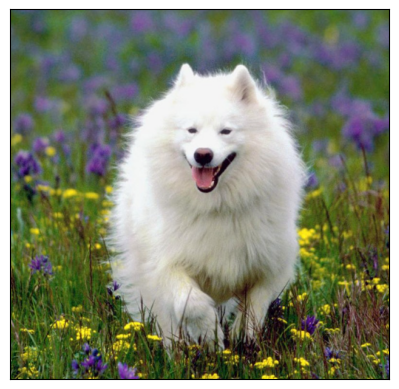

In [5]:
dog = Image.open('examples/dog.png').convert('RGB')
dog_tensor = transform(dog).unsqueeze(0)
H, W = dog_tensor.shape[-2:]

# show img after transform
plt.xticks([]), plt.yticks([])
plt.imshow(dog)

In [6]:
img = transform(dog).unsqueeze(0)
img = img.to(device)
output = model(torch.cat([img, img], 0))
target_index = torch.argmax(output[0]).cpu()
print('Predicted:', IMAGENET_1k_LABELS[target_index.item()])


Predicted: Samoyed, Samoyede


In [7]:
@torch.no_grad()
def normalize_saliency(saliency_map, return_device=torch.device('cpu')):
    B, C, H, W = saliency_map.size()
    if C > 1: # the input image is multi-channel
        saliency_map = saliency_map.max(dim=1, keepdim=True)[0]
    saliency_map = F.relu(saliency_map, [0])
    # the shape is B x 1 x H x W, normalize the saliency map along the channel dimension
    saliency_map = saliency_map.view(saliency_map.size(0), -1)
    saliency_map -= saliency_map.min(dim=1, keepdim=True)[0]
    saliency_map /= saliency_map.max(dim=1, keepdim=True)[0]
    saliency_map = saliency_map.view(B, 1, H, W)
    return saliency_map.to(return_device)

def visualize_single_saliency(saliency_map, img_size=None):
    B, C, H, W = saliency_map.size()
    assert B == 1, 'The input saliency map should not be batch inputs'
    if saliency_map.max() > 1 or C > 1:
        saliency_map = normalize_saliency(saliency_map)
    saliency_map = saliency_map.view(H, W, 1)
    saliency_map = saliency_map.cpu().numpy()
    if img_size is not None:
        saliency_map = cv2.resize(saliency_map, (img_size[1], img_size[0]), interpolation=cv2.INTER_LINEAR)
    else:
        saliency_map = cv2.resize(saliency_map, (W, H), interpolation=cv2.INTER_LINEAR)
    saliency_map = cv2.applyColorMap(np.uint8(saliency_map * 255.0), cv2.COLORMAP_JET)
    saliency_map = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(saliency_map)

In [8]:
gradients_net = VanillaGradient(model)
gradients = gradients_net.get_mask(img, torch.tensor([target_index], dtype=torch.long))
gradients = normalize_saliency(gradients)

In [9]:
ig_net = IntegratedGradients(model)
integrated_gradients = ig_net.get_mask(img, torch.tensor([target_index], dtype=torch.long),
                                       baseline='black', steps=256)
integrated_gradients = normalize_saliency(integrated_gradients)

In [10]:
blur_ig_net = BlurIG(model)
blur_integrated_gradients = blur_ig_net.get_mask(img, torch.tensor([target_index], dtype=torch.long),
                                                 batch_size=4, steps=20)
blur_integrated_gradients = normalize_saliency(blur_integrated_gradients)

In [11]:
from gradients_visualization import GuidedIG
guided_ig_net = GuidedIG(model)
guided_integrated_gradients = guided_ig_net.get_mask(img, torch.tensor([target_index], dtype=torch.long),
                                                 baseline='None', steps=256, max_dist=0.01, fraction=0.25)
guided_integrated_gradients = normalize_saliency(guided_integrated_gradients)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


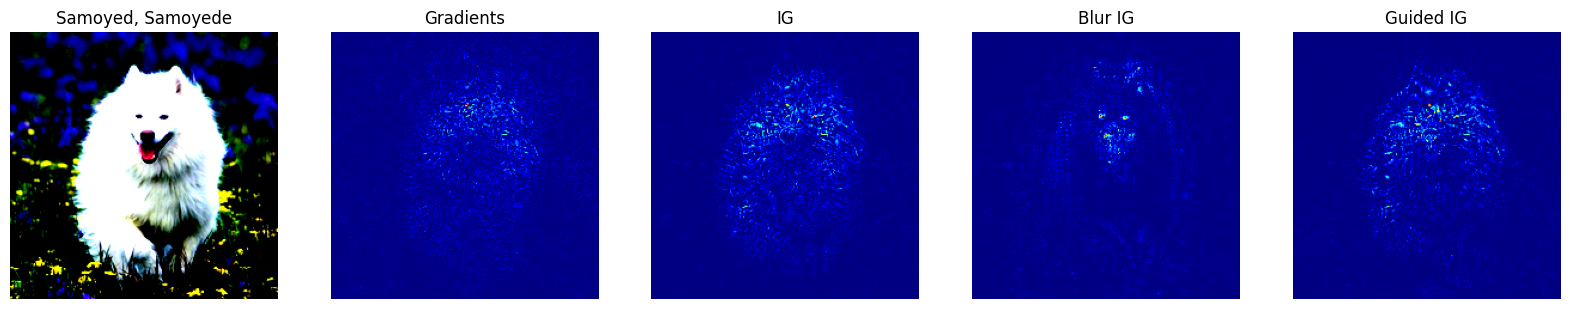

In [12]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plt.title(f'{IMAGENET_1k_LABELS[target_index.item()]}')
plt.axis('off')
plt.imshow(dog_tensor[0].permute(1, 2, 0))
plt.subplot(1, 5, 2)
plt.title(f'Gradients')
visualize_single_saliency(gradients, img_size=(H, W))
plt.subplot(1, 5, 3)
plt.title(f'IG')
visualize_single_saliency(integrated_gradients, img_size=(H, W))
plt.subplot(1, 5, 4)
plt.title(f'Blur IG')
visualize_single_saliency(blur_integrated_gradients, img_size=(H, W))
plt.subplot(1, 5, 5)
plt.title(f'Guided IG')
visualize_single_saliency(guided_integrated_gradients, img_size=(H, W))

# CAM methods on CNN

In [13]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
model = timm.create_model('resnet50', pretrained=True)
model = model.to(device)
model.eval()
config = resolve_model_data_config(model, None)
transform = create_transform(**config)

#for target_layer in model.named_modules():
#    print(target_layer)

In [14]:
# model.stages[-1]

In [15]:
target_layers = [model.layer4]
input_tensor = transform(dog).unsqueeze(0).to(device)
cam = XGradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(target_index)]

cam_img = cam(input_tensor=input_tensor, targets=targets)



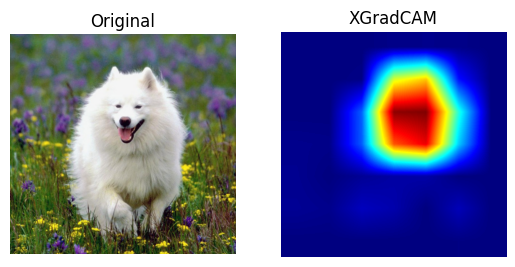

In [16]:
cam_img = torch.tensor(cam_img).unsqueeze(0)
cam_img = normalize_saliency(cam_img)
plt.figure()
plt.subplot(1,2,1)
plt.title('Original')
plt.axis('off')
plt.imshow(dog)
plt.subplot(1,2,2)
plt.title('XGradCAM')
visualize_single_saliency(cam_img, img_size=(H, W))